In [6]:
from sklearn.ensemble import RandomForestClassifier
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.models import Sequential, Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf

### setup our data

In [7]:
i = 0
train_dr = '/kaggle/input/clean-augmented-anemia-dataset/New_Augmented_Anemia_Dataset/Conjuctiva/Training'
valid_dr = '/kaggle/input/clean-augmented-anemia-dataset/New_Augmented_Anemia_Dataset/Conjuctiva/Validation'
anemia_data_dir = '/kaggle/input/clean-augmented-anemia-dataset/New_Augmented_Anemia_Dataset/Conjuctiva/Training/Anemic'
for item in os.listdir(anemia_data_dir) :
    i +=1
print(f"number of training data is {i}")
i = 0
non_anemia_data_dir = '/kaggle/input/clean-augmented-anemia-dataset/New_Augmented_Anemia_Dataset/Conjuctiva/Training/Non-Anemic'
i = 0
for item in os.listdir(non_anemia_data_dir) :
    i +=1
print(f"number of training non anemic data is {i}")

number of training data is 4219
number of training non anemic data is 4037


In [8]:
## viz images :
from tensorflow.keras.preprocessing.image import load_img
img = "/kaggle/input/clean-augmented-anemia-dataset/New_Augmented_Anemia_Dataset/Finger_Nails/Training/Anemic/Anemic-FN-001_aug1.png"
img_1 = load_img(img)
img_1.size

(224, 224)

### Load our data (using ImageDataGenerator) and  , rescale it 

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Rotate images by 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Shift images vertically by 20% of the height
    shear_range=0.2,  # Shear intensity (shear angle in radians)
    zoom_range=0.2,  # Zoom range [1-zoom_range, 1+zoom_range]
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill mode for filling in newly created pixels
)

### resize the images

In [12]:
train_generator = datagen.flow_from_directory(
    train_dr,  # Path to the training data directory
    target_size=(64, 64),  # Resize images to (64, 64)
    batch_size=32,
    class_mode='binary'  # Assuming binary classification (change as needed)
)

Found 8256 images belonging to 2 classes.


In [13]:
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    valid_dr,  # Path to the validation data directory
    target_size=(64, 64),  # Resize images to (64, 64)
    batch_size=32,
    class_mode='binary'  # Assuming binary classification (change as needed)
)

Found 1000 images belonging to 2 classes.


### test our result

In [29]:
for item in train_generator : 
    print(item[1].shape)
    break

(32,)


### build model architacteur

In [30]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPool2D, GlobalAveragePooling2D
inputs = Input(shape=(64,64,3))

x1 = (Conv2D(32, (2,2), input_shape=(64,64,3), padding="same", activation="relu"))(inputs)
x2 = (MaxPool2D(2,2))(x1)
x3 = (Conv2D(64, (2,2), padding="same", activation="relu"))(x2)
x4 = (MaxPool2D(2,2))(x3)
x5 = (Conv2D(128, (2,2), padding="same", activation="relu"))(x4)
x6 = (MaxPool2D(2,2))(x5)

x7 = (GlobalAveragePooling2D())(x6)
x8 = (Dense(100, activation="relu"))(x7)
x9 = (Dense(1, activation="sigmoid"))(x8)
# Define input shape and number of classes
model = Model(inputs=inputs, outputs=x9)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,569 (213.16 KB)

 Trainable params: 54,569 (213.16 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy() ,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [35]:
history = model.fit(train_generator,validation_data=valid_generator, epochs=100)

Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - accuracy: 0.8833 - loss: 0.2710 - val_accuracy: 0.8350 - val_loss: 0.3686
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - accuracy: 0.8918 - loss: 0.2582 - val_accuracy: 0.8730 - val_loss: 0.3113
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - accuracy: 0.8913 - loss: 0.2585 - val_accuracy: 0.8780 - val_loss: 0.3148
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - accuracy: 0.8772 - loss: 0.2914 - val_accuracy: 0.8860 - val_loss: 0.2751
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - accuracy: 0.9054 - loss: 0.2268 - val_accuracy: 0.8780 - val_loss: 0.3142
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - accuracy: 0.9052 - loss: 0.2380 - val_accuracy: 0.8680 - val_loss: 0.2945
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - accuracy: 0.8985 - loss: 0.2435 - val_accuracy: 0.9030 - val_loss: 0.2359
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.9049 -

### save the model to use it 

In [36]:
model.save('model_anemia.h5')

### see our results

In [37]:
import pandas as pd
model_information = pd.DataFrame(history.history)
model_information

,accuracy,loss,val_accuracy,val_loss
0,0.883236,0.270933,0.835,0.368605
1,0.891836,0.253711,0.873,0.311327
2,0.895107,0.252088,0.878,0.314836
3,0.889050,0.260458,0.886,0.275128
4,0.901405,0.234130,0.878,0.314204
...,...,...,...,...
95,0.964632,0.094696,0.944,0.158927
96,0.965480,0.099742,0.952,0.114696
97,0.961967,0.098744,0.957,0.093978
98,0.969234,0.085573,0.964,0.111395


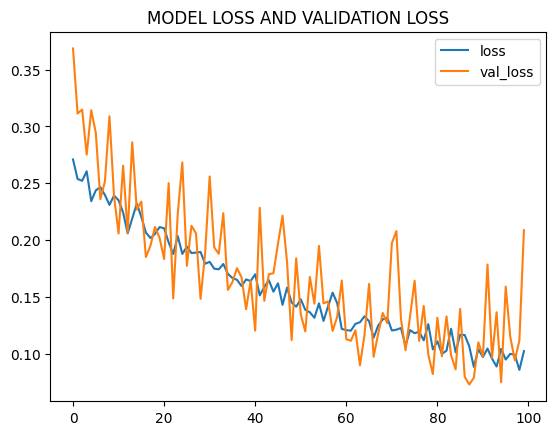

In [38]:
"""VISULIZE MODEL """
plt.plot(np.arange(100) , model_information['loss'] , label="loss")
plt.plot(np.arange(100) , model_information['val_loss'] , label="val_loss")
plt.title('MODEL LOSS AND VALIDATION LOSS')
plt.savefig('MOBILE_pretrained_loss.png')
plt.legend()
plt.show()

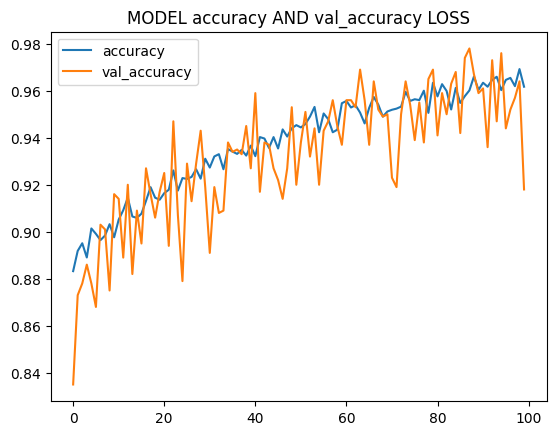

In [39]:
"""VISULIZE MODEL """
plt.plot(np.arange(100) , model_information['accuracy'] , label="accuracy")
plt.plot(np.arange(100) , model_information['val_accuracy'] , label="val_accuracy")
plt.title('MODEL accuracy AND val_accuracy LOSS')
plt.savefig('MOBILE_pretrained_val_accuracy.png')
plt.legend()
plt.show()

In [40]:
###test data
import os
test_images = []
test_data  = "/kaggle/input/clean-augmented-anemia-dataset/New_Augmented_Anemia_Dataset/Conjuctiva/Testing"
for item in os.listdir(test_data) :
      for img in os.listdir(os.path.join(test_data , item)) :
        test_images.append([os.path.join(test_data ,item , img ), item])

In [41]:
import random
random.shuffle(test_images)

In [47]:
test = test_images[0]
img = test[0]
label = test[1]

In [48]:
label

'Non-Anemic'

In [56]:
class_names = train_generator.class_indices
classes = list(class_names.keys())
classes

['Anemic', 'Non-Anemic']

### evaluation 

In [61]:
test_data_eval = model.evaluate(valid_generator)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9153 - loss: 0.2153


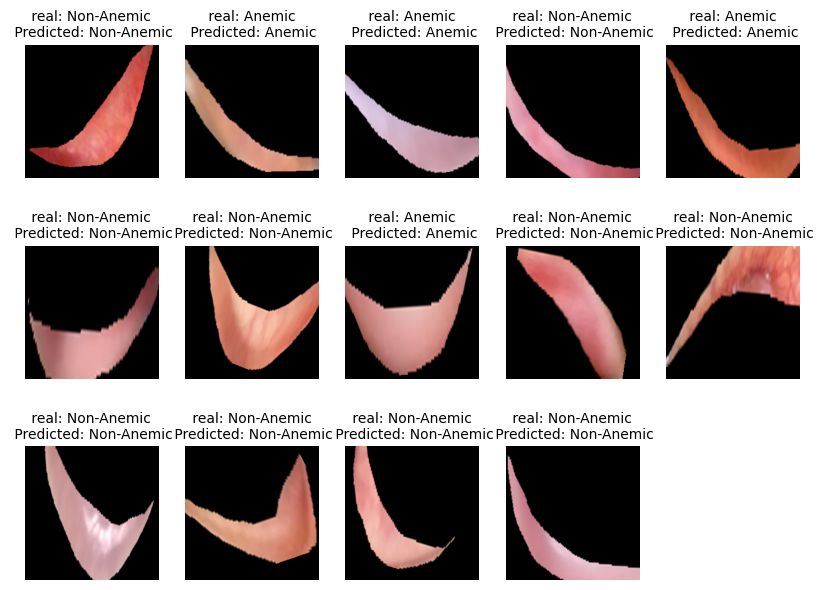

In [60]:
#TEST VISULIZATION
from tensorflow.keras.preprocessing import image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(64, 64))  # Assuming your model expects 64x64 images
    img = image.img_to_array(img)
    img = img /255.0
    img = np.expand_dims(img, axis=0)
    return img

# Function to predict class and visualize the image
def predict_and_visualize(image_paths):
    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(image_paths):
        img = preprocess_image(img_path[0])
        prediction = model.predict(img , verbose=0)
        
        predicted_class = classes[int(prediction.round()[0][0])]

        # Load and display the image
        plt.subplot(4, 5, i+1)
        plt.imshow(image.load_img(img_path[0]))
        plt.title(f' real: {img_path[1]} \n Predicted: {predicted_class}' , fontsize=10 )
        plt.axis('off')
    plt.savefig('result.png')
    plt.show()
    
predict_and_visualize(test_images[:14])